In [ ]:
!wget https://russiansuperglue.com/tasks/download/TERRa

--2021-06-26 10:28:46--  https://russiansuperglue.com/tasks/download/TERRa
Resolving russiansuperglue.com (russiansuperglue.com)... 37.18.107.48
Connecting to russiansuperglue.com (russiansuperglue.com)|37.18.107.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 907346 (886K) [application/zip]
Saving to: ‘TERRa’

TERRa               100%[===================>] 886.08K  1.29MB/s    in 0.7s    

2021-06-26 10:28:48 (1.29 MB/s) - ‘TERRa’ saved [907346/907346]



In [ ]:
!mv TERRa TERRa.zip

In [ ]:
!unzip TERRa.zip

Archive:  TERRa.zip
   creating: TERRa/
  inflating: TERRa/train.jsonl       
   creating: __MACOSX/
   creating: __MACOSX/TERRa/
  inflating: __MACOSX/TERRa/._train.jsonl  
  inflating: TERRa/.DS_Store         
  inflating: __MACOSX/TERRa/._.DS_Store  
  inflating: TERRa/test.jsonl        
  inflating: __MACOSX/TERRa/._test.jsonl  
  inflating: TERRa/val.jsonl         
  inflating: __MACOSX/TERRa/._val.jsonl  
  inflating: __MACOSX/._TERRa        


In [ ]:
!head TERRa/train.jsonl

{"premise": "Женщину доставили в больницу, за ее жизнь сейчас борются врачи.", "hypothesis": "Женщину спасают врачи.", "label": "entailment", "idx": 0}
{"premise": "Он проводит невидимую грань между настоящим и будущим. В эти минуты все мы подводим главные итоги года, вспоминаем самые важные события. В эти мгновения мы с волнением ждем добрых перемен.", "hypothesis": "В эти минуты все мы подводим друг друга.", "label": "not_entailment", "idx": 1}
{"premise": "Мужчина рассказал: детская коляска, принадлежащая его семье, пропала прямо из подъезда. Как выяснили полицейские, коляску украл сосед мужчины. Он был пьян, и ему нужны были деньги.", "hypothesis": "Сосед часто крадет детские коляски ради денег.", "label": "not_entailment", "idx": 2}
{"premise": "Я просто об этом даже не думаю, потому что если кто-то что-то захочет, никуда не спрячешься.", "hypothesis": "Спрятаться не удастся.", "label": "entailment", "idx": 3}
{"premise": "В ходе проверки нашли дома с наледью и сосульками на крыша

In [ ]:
import json
import os
class DataReader():

  file_mapping = {
      "TRAIN": "train.jsonl",
      "TEST": "test.jsonl",
      "VALID": "val.jsonl"
  }

  def __init__(self, dir_path):
      self.train_samples = self.read_file(dir_path, "TRAIN")
      self.test_samples = self.read_file(dir_path, "TEST")
      self.valid_samples = self.read_file(dir_path, "VALID")

  def read_file(self, dir_path, file_name):
      file_path = os.path.join(dir_path, self.file_mapping[file_name])
      jsonl_content = open(file_path).read()
      samples = [json.loads(jline) for jline in jsonl_content.splitlines()]
      print(f"Number of samples - {len(samples)} - in {file_name} dataset ")
      return samples

In [ ]:
import pandas as pd


class DataProcessor():

  sentence_keys = ["premise", "hypothesis"]
  target_label_key = "label"
  
  sentence_separator = "\n"
  dataframe_keys = ["text", "labels"]

  def __init__(self, samples):
    self.text_data, self.target_labels = self.prepare_data(samples)

  def prepare_data(self, samples):
    sentences_pairs = []
    labels = []
    for indx, sample in enumerate(samples):
      assert isinstance(sample, dict), \
       f"type(sample) should be dict but sample #{indx} is {type(sample)}"
      sentences_pair = []
      for sentence_key in self.sentence_keys:
        sentences_pair.append(sample[sentence_key])
      sentences_pair = self.sentence_separator.join(sentences_pair)
      sentences_pairs.append(sentences_pair)
      labels.append(sample.get(self.target_label_key))

    return sentences_pairs, labels

  def to_dataframe(self):
    return pd.DataFrame({
        self.dataframe_keys[0]: self.text_data,
        self.dataframe_keys[1]: self.target_labels,
        })
        
dp_train = DataProcessor(dr.train_samples).to_dataframe()
dp_valid = DataProcessor(dr.valid_samples).to_dataframe()



'from AbstractStep'

In [ ]:
def sp(string):
    return len(string.split())
    
class Statistics():
    def __init__(self,data):
        self.data_set = data
        self.new_data = self.data_set.copy()
    def description(self):
        self.new_data["number_of_tokens"] = self.new_data["text"].apply(sp)
        self.new_data["number_of_characters"] =  self.new_data["text"].apply(len)
        return self.new_data.describe()
a = Statistics(dp_train) 
#a.data_set 
a.description()
#dp_train

,number_of_tokens,number_of_characters
count,2616.000000,2616.000000
mean,39.217890,284.652905
std,19.882848,147.238266
min,8.000000,44.000000
25%,23.000000,166.000000
50%,36.000000,260.000000
75%,52.000000,371.000000
max,130.000000,978.000000


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='liblinear', random_state=17)
tf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.95, min_df=14)

In [ ]:
#!pip install ipymarkup
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from ipymarkup import show_span_line_markup
import warnings
warnings.filterwarnings("ignore")

class ModelTrainer():

  def __init__(self, featurizer, model):
    self.featurizer = featurizer
    self.model = model
    self.is_fit = False

  def fit(self, train_data):
    transformed_data = self.featurizer.fit_transform(train_data.text)
    print("Data was featurized")
    self.model.fit(transformed_data, train_data.labels)
    print("Model was fitted")
    self.is_fit = True

  def valid(self, valid_data):
    if self.is_fit:
      transformed_data = self.featurizer.transform(valid_data.text)
      predicted_labels = self.model.predict(transformed_data)
      self.eval_result(predicted_labels, valid_data.labels)
      self.vizualize_samples(valid_data, predicted_labels)
      print("Plot confusion matrix")
      plot_confusion_matrix(self.model, transformed_data, valid_data.labels, normalize='true')
    else:
      raise ValueError("First use method \"fit\" of ModelTrainer")

  def eval_result(self, predicted_labels, target_labels):
    print("Classification Report")
    print(metrics.classification_report(target_labels, predicted_labels))

  def vizualize_samples(self, valid_data, predicted_labels):
      valid_data["predicted_labels"] = predicted_labels
      print()
      print("Prediction samples")
      for indx, row in valid_data.sample(5).iterrows():
        sentences = row.text.split(DataProcessor.sentence_separator)
        print(f"Sample #{indx} \t Target label: {row.labels} \t Predicted label: {row.predicted_labels}")


Number of samples - 2616 - in TRAIN dataset 
Number of samples - 3198 - in TEST dataset 
Number of samples - 307 - in VALID dataset 
Data was featurized
Model was fitted
Classification Report
                precision    recall  f1-score   support

    entailment       0.49      0.54      0.51       153
not_entailment       0.49      0.43      0.46       154

      accuracy                           0.49       307
     macro avg       0.49      0.49      0.48       307
  weighted avg       0.49      0.49      0.48       307


Prediction samples
Sample #60 	 Target label: not_entailment 	 Predicted label: not_entailment
Sample #192 	 Target label: not_entailment 	 Predicted label: not_entailment
Sample #144 	 Target label: entailment 	 Predicted label: entailment
Sample #159 	 Target label: not_entailment 	 Predicted label: not_entailment
Sample #50 	 Target label: not_entailment 	 Predicted label: not_entailment
Plot confusion matrix


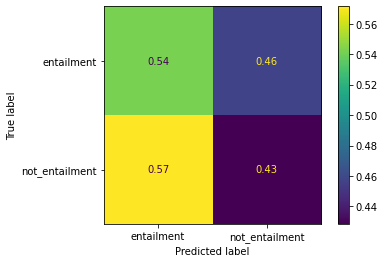

In [ ]:
class CustomPipeline():
    def __init__(self,PATH,featurizer, model):
        self.reader = DataReader(PATH)
        self.train = Statistics(DataProcessor(self.reader.train_samples).to_dataframe())
        self.valid = Statistics(DataProcessor(self.reader.valid_samples).to_dataframe())
        self.model = ModelTrainer(featurizer, model)
        #self.stat = Statistics(self.train)
    def run(self):
        fit = self.model.fit(self.train.data_set)
        valid = self.model.valid(self.valid.data_set)
        return valid 


m = CustomPipeline("/content/TERRa",tf_vectorizer, log_reg)  
m.run()

  



In [ ]:
m.train.description()

,number_of_tokens,number_of_characters
count,2616.000000,2616.000000
mean,39.217890,284.652905
std,19.882848,147.238266
min,8.000000,44.000000
25%,23.000000,166.000000
50%,36.000000,260.000000
75%,52.000000,371.000000
max,130.000000,978.000000
